This notebook demonstrates how to query the STAC API and return an xarray.

Queries are performed using [pystac_client](https://pystac-client.readthedocs.io/en/stable/) and data requested using [odc-stac](https://github.com/opendatacube/odc-stac)

Access https://edc-internal-earthkraken.eds.earthdaily.com/am/signin?tenant=core for your `CLIENT_ID` and `CLIENT_SECRET`

Since Venus scenes are LARGE we will select a smaller region of interest (ROI) within a scene to process. We will also use Dask to speed up calculations

## requirements.txt
```
dask
geopandas
shapely
IPython
numpy
matplotlib
xarray
pillow
pystac-client
odc-stac
pandas
bokeh==2.4.2
python-dotenv
boto3
leafmap
seaborn
rioxarray
rasterstats
```

In [1]:
# !pip install rioxarray

In [2]:
import boto3
import dask.distributed
from dotenv import load_dotenv
from folium import raster_layers
import folium
from glob import glob
import geopandas as gpd
from geopandas import GeoDataFrame
from IPython.display import display
import io
import json
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
from odc.stac import configure_rio, stac_load
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os
from pystac_client import Client
import pandas as pd
import rasterio
from rasterio.features import geometry_mask, geometry_window, rasterize
from rasterio.warp import transform_geom
import rasterio.mask
import re
import requests
import rioxarray
from rasterstats import zonal_stats
from shapely.affinity import affine_transform
from shapely.geometry import box, shape
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import shapely.geometry
from urllib.parse import urlparse

import rasterio
from rasterio.transform import from_origin

In [3]:
load_dotenv()  # take environment variables from .env.

STACK_URL = "https://api.eds.earthdaily.com/archive/v1/stac/v1" # public, requires auth with client ID & SECRERT
ACCESS_TOKEN_URL = "https://core-earthdaily.auth.us-east-1.amazoncognito.com/oauth2/token"
SITE = "DENVER" # site name in this tutorial

In [4]:
# run dask cluster, just run once per session
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62652,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:62666,Total threads: 2
Dashboard: http://127.0.0.1:62668/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:62655,


Retreive STAC credentials for EDA catalogue from `.env` which you will need to modify from `.env.sample`

In [5]:
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

Authenticate with the STAC API, if you get an error check your client ID & SECRERT.

We also create a catalog for element84 API which hosts Sentinel 2 imagery

In [6]:
def get_new_token():
    auth_server_url = ACCESS_TOKEN_URL
    client_id = CLIENT_ID
    client_secret = CLIENT_SECRET
    token_req_payload = {'grant_type': 'client_credentials'}

    token_response = requests.post(
        auth_server_url,
        data=token_req_payload,
        verify=False,
        allow_redirects=False,
        auth=(client_id, client_secret)
    )
    token_response.raise_for_status()

    tokens = json.loads(token_response.text)
    return tokens['access_token']

token = get_new_token()

catalog = Client.open(STACK_URL, headers={
    "Authorization": f"bearer {token}"
})

# e84_catalog = Client.open("https://earth-search.aws.element84.com/v0") # allow switching between E84 and EDA to access different datasets

/Users/robin.cole/scratchpad/venus-multi-location/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'core-earthdaily.auth.us-east-1.amazoncognito.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


# Now select mission & catalogue
Edit the cell below to select between "S2" or "VENUS"

In [7]:
SATELLITE = "VENUS" # "S2" or "VENUS"

In [8]:
if SATELLITE == "S2":
    # catalog = e84_catalog
    COLLECTION = "sentinel-s2-l2a"
    BANDS = ("B04", "B03", "B02")
elif SATELLITE == "VENUS":
    catalog = catalog
    COLLECTION = "venus-l2a"
    BANDS = ("red", "green", "blue", "nir08", "rededge", "yellow", "coastal") # , 

OUTPUTS_DIR = f"outputs_{SITE}_{SATELLITE}/" # location where the output files will be saved
if not os.path.exists(OUTPUTS_DIR):
    os.makedirs(OUTPUTS_DIR)

EMPTY_OUTPUTS_DIR = True # set to True to delete all files in OUTPUTS_DIR before running the notebook
if EMPTY_OUTPUTS_DIR:
    for f in glob(OUTPUTS_DIR + "*"):
        os.remove(f)

print(f"Using {SATELLITE} data from {catalog.description}")
print(f"Writing outputs to {OUTPUTS_DIR}")

Using VENUS data from stac-fastapi
Writing outputs to outputs_DENVER_VENUS/


In [9]:
# List collections to see what is available
# for collection in catalog.get_collections():
#     print(collection.id)

Add ROI

In [10]:
ROI = {'type': 'Feature',
 'properties': {},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-104.982777, 39.788159],
    [-104.982777, 39.820865],
    [-104.912739, 39.820865],
    [-104.912739, 39.788159],
    [-104.982777, 39.788159]]]}}

In [11]:
def get_bounds_polygon_dict(polygon_dict: dict) -> tuple:
    gdf = gpd.GeoDataFrame.from_features([polygon_dict])
    polygon = gdf.geometry.iloc[0]
    bounds = polygon.bounds
    return bounds

try:
    bbox = get_bounds_polygon_dict(ROI)
    print(bbox)
except:
    print("Draw a polygon using the rectangle tool")

(-104.982777, 39.788159, -104.912739, 39.820865)


Set your remaining filter parameters and perform the query

In [12]:
# Set a start and end date
YEAR = 2023
start_date = f"{YEAR}-08-01"
end_date = f"{YEAR}-09-01"
max_clouds = 5 # the maximum cloud cover percentage. Note this is over the WHOLE image, not just the ROI

query = catalog.search(
    collections=[COLLECTION], 
    datetime=f"{start_date}/{end_date}",
    bbox=bbox,
    # query={"eo:cloud_cover":{"lt":max_clouds}}, # uncomment to filter on cloud cover
)

items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

Found: 11 datasets


Just get a single

In [13]:
item = items[-1]

In [14]:
common_names = sorted(list(set([i['common_name'] for i in item.properties['eo:bands']])))

common_names

['blue', 'coastal', 'green', 'nir08', 'nir09', 'red', 'rededge', 'yellow']

We now use `stac_load` to retrieve an [xarray](https://docs.xarray.dev/en/stable/) dataset using the `items` returned by the STAC query

We use dask to lazy load the data - view the dask dashboard to monitor processing. Note that running this cell multiple times

In [15]:
BANDS

('red', 'green', 'blue', 'nir08', 'rededge', 'yellow', 'coastal')

In [16]:
dataset = stac_load(
    [item],
    bands=BANDS,
    crs="epsg:3857", # since resolution is in metres, we need to use a projected CRS
    resolution=5, # the reoslution of the output image in metres
    chunks={},  # <-- use Dask
    groupby="id",
    bbox=bbox,
)

display(dataset)

<xarray.Dataset>
Dimensions:      (y: 948, x: 1560, time: 1)
Coordinates:
  * y            (y) float64 4.84e+06 4.84e+06 4.84e+06 ... 4.835e+06 4.835e+06
  * x            (x) float64 -1.169e+07 -1.169e+07 ... -1.168e+07 -1.168e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2023-08-02T17:40:11
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 948, 1560), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 948, 1560), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 948, 1560), meta=np.ndarray>
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 948, 1560), meta=np.ndarray>
    rededge      (time, y, x) uint16 dask.array<chunksize=(1, 948, 1560), meta=np.ndarray>
    yellow       (time, y, x) uint16 dask.array<chunksize=(1, 948, 1560), meta=np.ndarray>
    coastal      (time, y, x) uint16 dask.array<chunksize=(1, 948, 1560), meta=np.ndarray>

Data is loaded lazily - we call `.compute()` to load the data, this can take minutes if there are many images to load or the bbox is large

In [17]:
%%time
dataset = dataset.compute()

CPU times: user 374 ms, sys: 126 ms, total: 500 ms
Wall time: 7.27 s


In [18]:
dataset = dataset.isel(time=0)

Let's create an RGB image

CPU times: user 610 ms, sys: 37.3 ms, total: 647 ms
Wall time: 672 ms


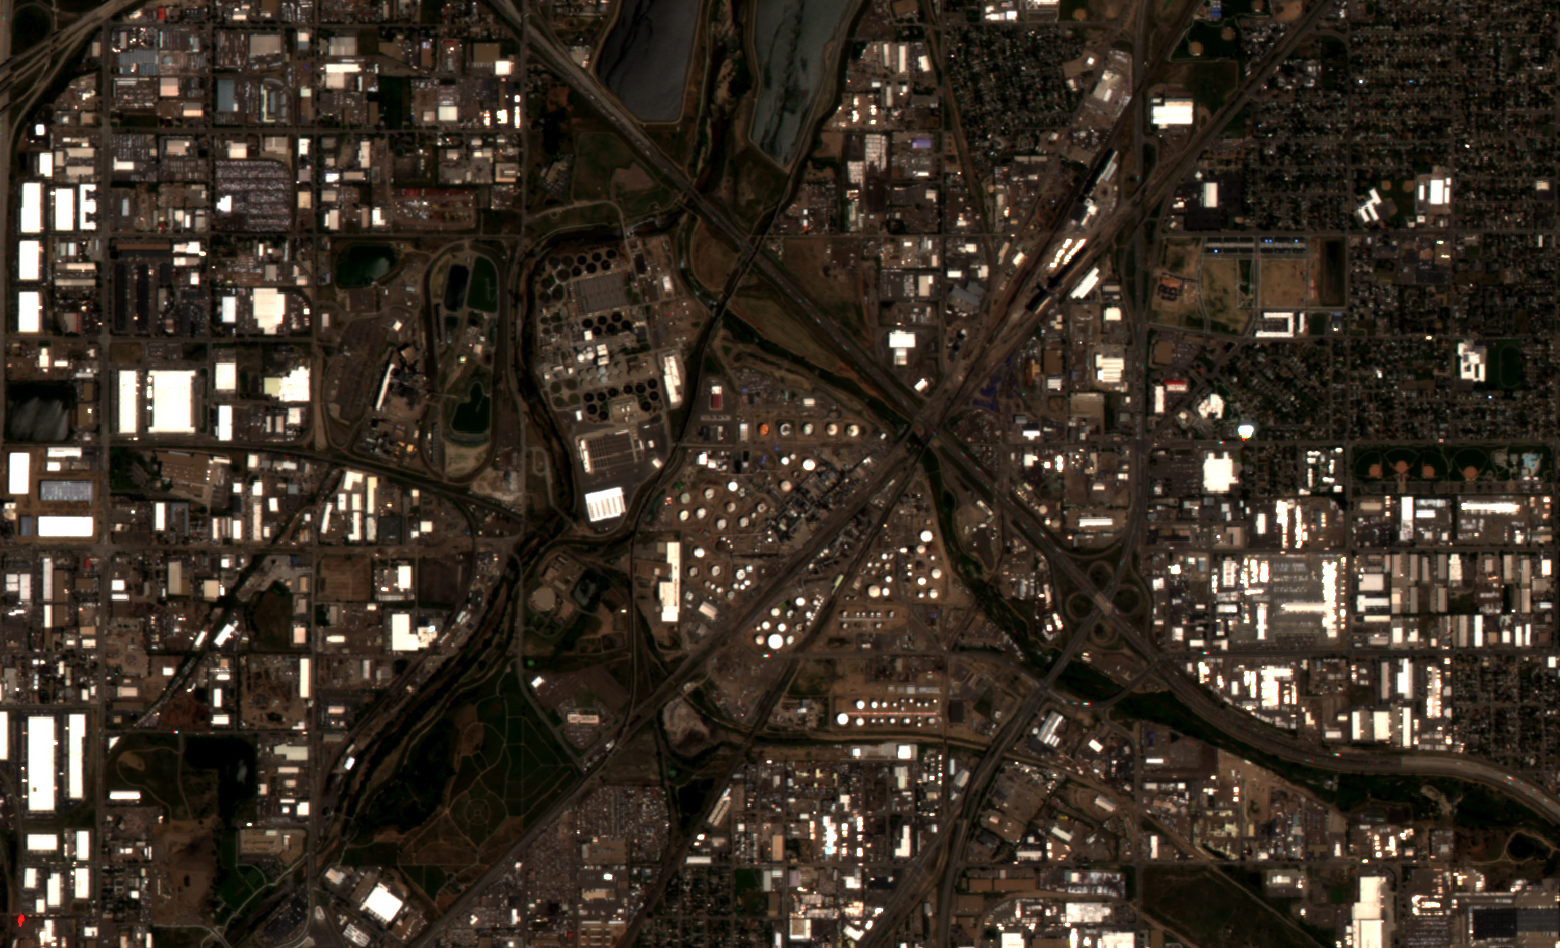

In [20]:
%%time
def normalise_img(x):
    "Scale pixel values to 0-1 range"
    return x / x.max()

def contrast_stretch(img: np.ndarray) -> np.ndarray:
    p2, p98 = np.percentile(img, (2, 98))
    return np.clip((img - p2) / (p98 - p2), 0, 1)


# ds = dataset.isel(time=0)
# dataarray = ds.to_array("band")
dataarray = dataset.to_array("band").sel(band=['red', 'green', 'blue'])  # Assuming the band names are 'red', 'green', 'blue'
# dataarray = ds.to_array("band").sel(band=['nir08', 'green', 'blue'])  # False colour
date = dataarray.time.values
date = pd.to_datetime(date).strftime("%Y-%m-%d")
rgb_numpy_array = np.transpose(dataarray.values, (1, 2, 0))
if SATELLITE == "VENUS":
    rgb_numpy_array = rgb_numpy_array - 1000 # normalise offset
rgb_numpy_array = contrast_stretch(rgb_numpy_array)
rgb_numpy_array = normalise_img(rgb_numpy_array)
rgb_image = Image.fromarray((rgb_numpy_array * 255).astype(np.uint8))
rgb_image.save(OUTPUTS_DIR + f"{SITE}_{date}.png")

rgb_image

Write RGB geotif

In [21]:
# Get CRS and transform from the xarray dataset
crs = "epsg:3857" # dataset.crs
# transform = dataset.transform

# Calculate transform
x_min, y_max = dataset.x.min(), dataset.y.max()
pixel_size_x, pixel_size_y = 5, 5
transform = from_origin(x_min, y_max, pixel_size_x, pixel_size_y)
# print(transform)

# Convert xarray dataset to numpy array and get dimensions
rgb_array = dataset.to_array().values  # Replace this with the correct method if your `dataset` is not directly convertible
height, width, num_bands = rgb_numpy_array.shape


rgb_geotiff = OUTPUTS_DIR + f"{SITE}_{date}_rgb.tiff"

# Open a new GeoTIFF file in write mode
with rasterio.open(
    rgb_geotiff,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=num_bands,
    dtype=rgb_numpy_array.dtype,
    crs=crs,
    transform=transform
) as dst:
    # Write the bands
    for i in range(num_bands):
        dst.write(rgb_numpy_array[:, :, i], i + 1)

print(f"wrote {rgb_geotiff}")

wrote outputs_DENVER_VENUS/DENVER_2023-08-02_rgb.tiff


write multichannel

In [22]:
full_geotiff = OUTPUTS_DIR + f"{SITE}_{date}_ms.tiff"

In [23]:
# Set the CRS and spatial dimensions
dataset = dataset.rio.write_crs("epsg:3857")
dataset = dataset.rio.set_spatial_dims(x_dim="x", y_dim="y")

# Write to GeoTIFF
dataset.rio.to_raster(full_geotiff)
print(f"wrote {full_geotiff}")

wrote outputs_DENVER_VENUS/DENVER_2023-08-02_ms.tiff


## overlay building footprints
We now use building footprints from https://github.com/microsoft/USBuildingFootprints to generate training data. We will train a simple model to classify pixels as belonging to a building or not

In [24]:
gdf = gpd.read_file("/Users/robin.cole/Documents/datasets/USBuildingFootprints/Colorado.geojson")

minx, miny, maxx, maxy = bbox
gdf = gdf.cx[minx:maxx, miny:maxy] # Filter out only the polygons within the bounding box
gdf.head()

,release,capture_dates_range,geometry
31577,2,10/3/2018-12/4/2018,"POLYGON ((-104.91274 39.80685, -104.91255 39.8..."
31578,2,10/3/2018-12/4/2018,"POLYGON ((-104.91276 39.80909, -104.91260 39.8..."
31625,2,10/3/2018-12/4/2018,"POLYGON ((-104.91368 39.79784, -104.91378 39.7..."
31629,2,10/3/2018-12/4/2018,"POLYGON ((-104.91373 39.80907, -104.91361 39.8..."
31737,2,10/3/2018-12/4/2018,"POLYGON ((-104.91392 39.79731, -104.91392 39.7..."


<Axes: >

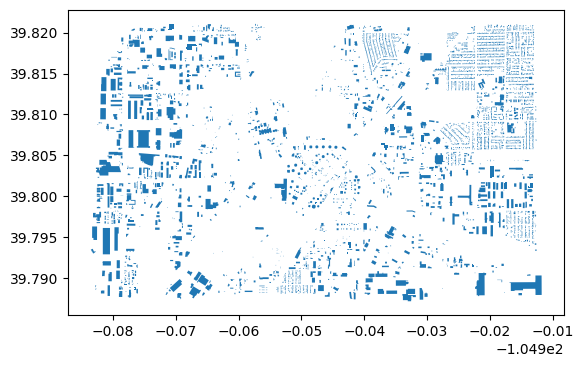

In [25]:
gdf.plot()

Make ML training data from building outlines - experiment with RGB or all bands

In [26]:
# raster_path = rgb_geotiff
raster_path = full_geotiff

raster_path

'outputs_DENVER_VENUS/DENVER_2023-08-02_ms.tiff'

In [27]:
def generate_training_data(raster_path: str, filtered_gdf: GeoDataFrame):
    "Open raster, pixels inside a poly are labelled 1, outside labelled zero"
    with rasterio.open(raster_path) as src:
        # Read all bands
        array = src.read()
        transform = src.transform
        inv_transform = ~src.transform

        # Initialize label array to zeros
        labels = np.zeros(array.shape[1:], dtype=np.uint8)
        filtered_gdf = filtered_gdf.to_crs(epsg=3857) # must match the raster
        print(f"Raster CRS: {src.crs}, Polygon CRS: {filtered_gdf.crs}")  # Debugging line

        for _, row in filtered_gdf.iterrows():
            polygon = row['geometry']
            if polygon is not None:
                # Transform polygon to raster CRS
                poly_transformed = transform_geom(filtered_gdf.crs, src.crs, shape(polygon).__geo_interface__)

                # Rasterize the transformed polygon
                rasterize([(poly_transformed, 1)], out_shape=labels.shape, transform=transform, fill=0, dtype=np.uint8, out=labels)

        print(f"Unique labels after rasterization: {np.unique(labels)}")  # Debugging line

        # Reshape for ML
        array = array.reshape((array.shape[0], -1)).T
        labels = labels.reshape(-1)
        return array, labels


# Generate training data
X, y = generate_training_data(raster_path, gdf)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Raster CRS: EPSG:3857, Polygon CRS: EPSG:3857
Unique labels after rasterization: [0 1]
Shape of X: (1478880, 7)
Shape of y: (1478880,)


Sanity check the generated mask

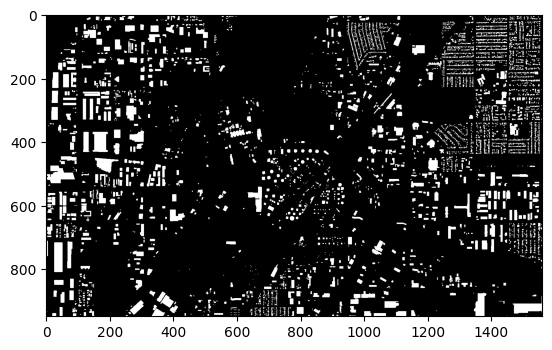

In [28]:
new_shape = (rgb_numpy_array.shape[0], rgb_numpy_array.shape[1])
plt.imshow(y.reshape(new_shape), cmap='Greys_r');

Check for imbalance

In [32]:
def calculate_imbalance(arr):
    # Count zeros and ones
    count_zeros = np.sum(arr == 0)
    count_ones = np.sum(arr == 1)
    
    # Calculate imbalance ratio
    if count_zeros == 0 or count_ones == 0:
        return "Array has only one class, cannot calculate imbalance."
    else:
        imbalance_ratio = max(count_zeros, count_ones) / min(count_zeros, count_ones)
        return imbalance_ratio
    
imbalance = int(calculate_imbalance(y.flatten()))
imbalance

8

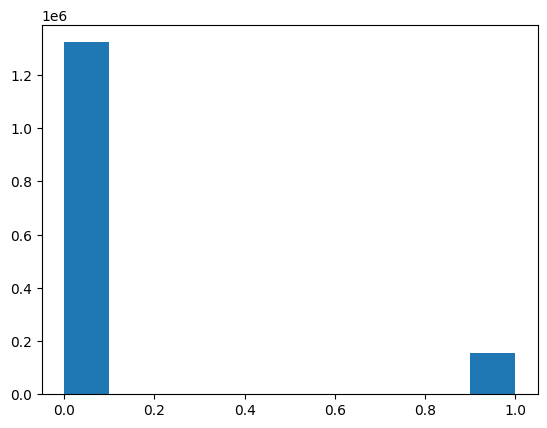

In [33]:
plt.hist(y.flatten());

In [34]:
# Random forest
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Create a Logistic Regression model with class weights
log_reg = LogisticRegression(class_weight={0: 1, 1: imbalance}, random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8582001244184788
              precision    recall  f1-score   support

           0       0.95      0.89      0.92    264557
           1       0.39      0.62      0.48     31219

    accuracy                           0.86    295776
   macro avg       0.67      0.75      0.70    295776
weighted avg       0.89      0.86      0.87    295776



- LR RGB Accuracy: 0.88
- LR MS Accuracy: 0.85

In [36]:
# Create a Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Validate the model
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['notbuilding', 'building']))

Accuracy: 0.9470173374445526
              precision    recall  f1-score   support

 notbuilding       0.96      0.99      0.97    264557
    building       0.84      0.61      0.71     31219

    accuracy                           0.95    295776
   macro avg       0.90      0.80      0.84    295776
weighted avg       0.94      0.95      0.94    295776



- RF RGB Accuracy: 0.91 # 1.5 mins
- RF RGB Accuracy: 0.95 # 2.5 mins

Now apply this to another location, or improve the model..!